# Project Phase 1 
## SimBoost


#### Name: Aryan Mikaeili
#### Student No.: 95105895


Drug discovery is a time-consuming, laborious, costly and high-risk process. According to a report by the Eastern Research Group (ERG), it usually takes 10-15 years to develop a new drug. However, the success rate of developing a new molecular entity is only 2.01%. \
Finding a compound that selectively binds to a particular protein is a highly challenging and typically expensive procedure in the drug development process. \
In this project we are going to implement [SimBoost](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5395521/#CR42) which is machine-learning approch for predicting drug–target binding affinities using gradient boosting.




We will be using [Davis](http://staff.cs.utu.fi/~aatapa/data/DrugTarget/) dataset, which contains selectivity assays of the kinase protein family and the relevant inhibitors with their respective dissociation constant (Kd) values. It comprises interactions of 442 proteins and 68 drugs.

## 1. Setup (15 Points)

### 1.1 Imports libs

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt


### 1.2 Loading data

We need following files for this project:
- `target_gene_names.txt`: gene names of the targets
- `drug_PubChem_CIDs.txt`: PubChem CIDs of the drugs
- `drug-drug_similarities_2D.txt`: drug-drug structural fingerprint similarities computed the Structure Clustering sever at PubChem
- `target-target_similarities_WS_normalized.txt`: target-target sequence similarities computed with the normalized versions of the Smith-Waterman (SW) score.
- `drug-target_interaction_affinities_Kd__Davis_et_al.2011.txt`: drug-target interaction affinities.

The rows (and columns) of the drug-drug similarity matrices correspond to the rows of the interaction affinity matrix and the rows (and columns) of the target-target similarity matrices correspond to the columns of the interaction affinity matrix.

In [2]:
target_gene_names = pd.read_csv("target_gene_names.txt", header=None, index_col = 0)
drug_pubchemIDs = pd.read_csv("drug_PubChem_CIDs.txt", header=None, index_col = 0) #  dtype=str
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Load each file using pd.read_csv and use target_gene_names and drug_pubchemIDs
# to correspond row index and columns of all three files.
# sim_targets.shape == (442, 442)
# sim_drugs.shape == (68, 68)
# bindings.shape == (68, 442)
# Note that target_gene_names and drug_pubchemIDs dataframes are empty, we are
# going to fill them with features.
#################################################################################
sim_targets = pd.read_csv("target-target_similarities_WS_normalized.txt", header = None, delimiter = " ")
sim_drugs = pd.read_csv("drug-drug_similarities_2D.txt", header = None, delimiter = " ")
bindings = pd.read_csv("drug-target_interaction_affinities_Kd__Davis_et_al.2011.txt", header = None, delimiter = " ")

sim_targets.columns = target_gene_names.index
sim_targets.index = target_gene_names.index

sim_drugs.columns = drug_pubchemIDs.index
sim_drugs.index = drug_pubchemIDs.index

bindings.columns = target_gene_names.index
bindings.index =  drug_pubchemIDs.index

#################################################################################
#                                   THE END                                     #
#################################################################################
sim_targets.shape, sim_drugs.shape, bindings.shape


((442, 442), (68, 68), (68, 442))

### 1.3 Preprocessing

In davis dataset, standard value is Kd in nM. we used the transformation below:

### $pK_{d}=-log_{10}\frac{K_d}{1e9}$ 


In [3]:
drug_pubchemIDs.sort_index(inplace=True)
target_gene_names.sort_index(inplace=True)
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# sort sim_targets, sim_drugs, bindings based on their index like above 
# divide all values of sim_targets by 100
# transform binding values as mentioned above
#################################################################################
sim_drugs.sort_index(inplace=True)
sim_drugs.sort_index(axis = 1, inplace=True)

sim_targets.sort_index(inplace=True)
sim_targets.sort_index(axis = 1, inplace=True)

sim_targets = np.divide(sim_targets, 100)
transformed_bindings = -np.log10(np.divide(bindings, 1e9))

transformed_bindings.sort_index(inplace=True)
transformed_bindings.sort_index(inplace=True)

#################################################################################
#                                   THE END                                     #
#################################################################################
transformed_bindings.head()

,AAK1,ABL1(E255K)-phosphorylated,ABL1(F317I)-nonphosphorylated,ABL1(F317I)-phosphorylated,ABL1(F317L)-nonphosphorylated,ABL1(F317L)-phosphorylated,ABL1(H396P)-nonphosphorylated,ABL1(H396P)-phosphorylated,ABL1(M351T)-phosphorylated,ABL1(Q252H)-nonphosphorylated,ABL1(Q252H)-phosphorylated,ABL1(T315I)-nonphosphorylated,ABL1(T315I)-phosphorylated,ABL1(Y253F)-phosphorylated,ABL1-nonphosphorylated,ABL1-phosphorylated,ABL2,ACVR1,ACVR1B,ACVR2A,ACVR2B,ACVRL1,ADCK3,ADCK4,AKT1,AKT2,AKT3,ALK,AMPK-alpha1,AMPK-alpha2,ANKK1,ARK5,ASK1,ASK2,AURKA,AURKB,AURKC,AXL,BIKE,BLK,...,TAOK2,TAOK3,TBK1,TEC,TESK1,TGFBR1,TGFBR2,TIE1,TIE2,TLK1,TLK2,TNIK,TNK1,TNK2,TNNI3K,TRKA,TRKB,TRKC,TRPM6,TSSK1B,TTK,TXK,TYK2(JH1domain-catalytic),TYK2(JH2domain-pseudokinase),TYRO3,ULK1,ULK2,ULK3,VEGFR2,VRK2,WEE1,WEE2,YANK1,YANK2,YANK3,YES,YSK1,YSK4,ZAK,ZAP70
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5291,5.000000,6.769551,8.080922,6.236572,8.602060,6.958607,8.229148,7.187087,7.356547,8.744727,7.036212,5.000000,5.000000,6.886057,8.958607,7.677781,8.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.0,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.283997,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.366532,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.000000,5.060481,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.585027,5.000000
44259,8.920819,7.657577,6.259637,6.886057,6.769551,7.337242,7.744727,7.443697,7.283997,7.677781,7.958607,8.075721,8.537602,7.638272,7.431798,7.657577,6.958607,6.327902,6.167491,5.05061,5.337242,5.000000,5.0,5.0,7.698970,7.356547,6.769551,7.494850,8.431798,7.920819,6.568636,8.356547,6.958607,6.585027,7.769551,7.721246,7.638272,8.167491,8.251812,7.823909,...,7.920819,9.657577,9.050610,5.886057,6.494850,5.698970,5.000000,7.187087,6.853872,7.568636,7.79588,8.327902,8.602060,7.795880,6.000000,8.397940,8.420216,7.769551,5.0,7.619789,7.214670,6.638272,7.251812,5.508638,6.552842,8.004365,9.102373,8.920819,6.657577,5.0,5.795880,5.000000,7.886057,7.008774,6.508638,7.283997,6.958607,9.065502,5.000000,7.356547
123631,5.000000,6.397940,5.000000,5.327902,5.568636,6.107905,6.167491,6.337242,6.283997,5.958607,6.638272,5.000000,5.000000,6.443697,5.657577,6.318759,5.795880,5.000000,5.000000,5.00000,5.000000,5.000000,5.0,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.744727,5.000000,5.920819,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.161151,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.221849,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.619789,5.000000,5.000000
126565,8.508638,6.075721,5.000000,5.309804,5.119186,5.657577,6.000000,6.060481,6.107905,5.602060,6.080922,6.022276,6.795880,6.040959,5.494850,6.000000,5.187087,7.124939,7.065502,5.60206,5.420216,5.657577,5.0,5.0,5.356547,5.677781,5.207608,7.148742,7.602060,7.251812,7.494850,8.431798,7.154902,6.769551,7.795880,7.795880,8.387216,7.455932,7.795880,6.795880,...,6.301030,7.065502,7.744727,5.920819,6.537602,6.920819,6.267606,6.167491,6.200659,6.958607,7.19382,8.267606,8.031517,8.180456,5.677781,8.080922,7.853872,7.853872,5.0,7.008774,8.187087,6.180456,7.823909,6.040959,6.187087,6.000000,7.221849,8.309804,6.657577,5.0,5.920819,5.102373,5.677781,5.229148,5.096910,6.795880,7.013228,9.283997,5.173925,7.795880
151194,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.0,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.0

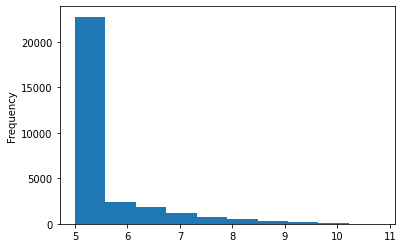

In [4]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Plot histogram of all values in transformed_bindings
# Hint: use .stack and .plot.hist  
#################################################################################
transformed_bindings.stack().plot.hist()


#################################################################################
#                                   THE END                                     #
#################################################################################

As you can see in histogram. The peak at pKd value 5 (10000 nM), These values correspond to the negative pairs that either have very weak binding affinities (Kd > 10000nM) or are not observed in the primary screen.

### 1.4 Drug-Target-Binding

In [5]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# use drug_target_binding and build drug_target_binding dataframe 
# in each row of dataframe you must have one drug-target pair and their 
# transformed binding value, in the end you must have a dataframe with 
# 30056 row and 3 columns ['Drug', 'Target', 'Binding_Val']
#################################################################################
drug_target_binding = None
drug_target_binding = pd.DataFrame(transformed_bindings.stack().index.tolist(),columns = ["Drug", "Target"])
drug_target_binding["Binding_Val"] = np.array(transformed_bindings.stack())
#################################################################################
#                                   THE END                                     #
#################################################################################
drug_target_binding.head()

,Drug,Target,Binding_Val
0,5291,AAK1,5.000000
1,5291,ABL1(E255K)-phosphorylated,6.769551
2,5291,ABL1(F317I)-nonphosphorylated,8.080922
3,5291,ABL1(F317I)-phosphorylated,6.236572
4,5291,ABL1(F317L)-nonphosphorylated,8.602060


### 1.5 Train, Validation and Test Datasets

In [6]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# split drug_target_binding dataframe to 3 sets (train_data, val_data, test_data)
# split ratio is up to you
# at the end you must have 3 sets that each of them has 3 columns
#################################################################################
train_data = None
val_data = None
test_data = None

test_ratio = 0.2
validation_ratio = 0.1
train_data, test_data = train_test_split(drug_target_binding, shuffle=True, test_size= test_ratio)
train_data, val_data= train_test_split(train_data, shuffle = True,  test_size= validation_ratio /(1 - test_ratio))

#################################################################################
#                                   THE END                                     #
#################################################################################
train_data.shape, val_data.shape, test_data.shape

((21038, 3), (3006, 3), (6012, 3))

## 2.Feature Engineering (35 Points)

In this part we are going to extract some feature for each target/drug. after that we will replace these features with their names/pubchemIDs. 

### 2.1 Average Similarities and Binding values

In [7]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# for each target compute their average similarities in sim_targets matrix
# and average binding value (in train_data).
# add these two feature as 'avg-sim', 'avg-binding' to target_gene_names DataFrame
#################################################################################
avg_binding = train_data.groupby("Target").mean()["Binding_Val"]
avg_sim = sim_targets.mean()
target_gene_names["avg_sim_target"] = avg_sim
target_gene_names["avg_bindings_target"] = avg_binding
#################################################################################
#                                   THE END                                     #
#################################################################################
target_gene_names.head()


,avg_sim_target,avg_bindings_target
0,,
AAK1,0.479173,5.604475
ABL1(E255K)-phosphorylated,0.535796,6.071441
ABL1(F317I)-nonphosphorylated,0.535796,5.536091
ABL1(F317I)-phosphorylated,0.535796,5.534115
ABL1(F317L)-nonphosphorylated,0.535796,5.793153


In [8]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# for each drug compute their average similarities in sim_drugs matrix
# and average binding value (in train_data).
# add these two feature as 'avg-sim', 'avg-binding' to drug_pubchemIDs DataFrame
#################################################################################
avg_binding = train_data.groupby("Drug").mean()["Binding_Val"]
avg_sim = sim_drugs.mean()
drug_pubchemIDs["avg_sim_drug"] = avg_sim
drug_pubchemIDs["avg_bindings_drug"] = avg_binding

#################################################################################
#                                   THE END                                     #
#################################################################################
drug_pubchemIDs.head()

,avg_sim_drug,avg_bindings_drug
0,,
5291,0.615412,5.181759
44259,0.559441,7.188980
123631,0.608265,5.266352
126565,0.530206,6.719549
151194,0.558706,5.067659


### 2.2 Drug/Target Similarity Networks

#### 2.2.1 Build Networks

You must build two networks one for drugs and another one for targets. The nodes are drugs or targets, and an edge between two nodes exists if their similarity is above a threshold. The value of threshold is up to you. \
For building networks, we are going to use [igraph](https://igraph.org/) package. 

In [0]:
import igraph

IGRAPH D-W- 68 738 -- 
+ attr: label (v), weight (e)
IGRAPH D-W- 442 11618 -- 
+ attr: weight (e)


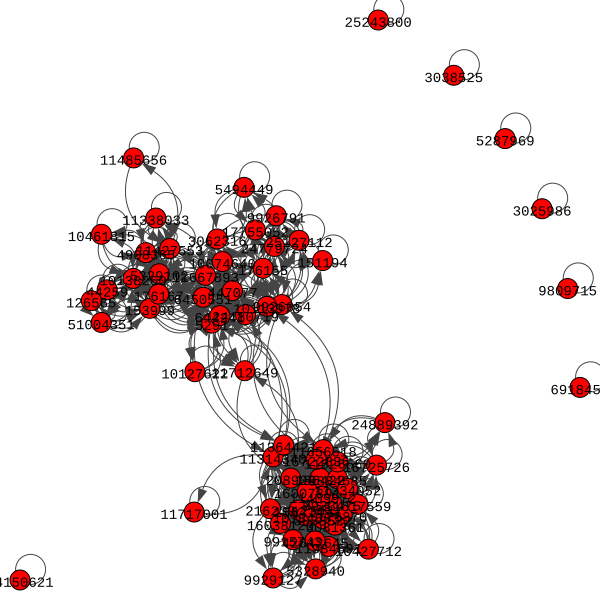

In [11]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# define drug_sim_threshold, target_sim_threshold and use these values to
# build two network one for drugs and another one for targets using sim_drugs
# and sim_targets.
# Hint: you can use igraph.Graph.Adjacency, you can plot your graph using 
# igraph.plot
#################################################################################
drug_sim_threshold = sim_drugs.values.mean() + 0.1
target_sim_threshold =  sim_targets.values.mean() + 0.1


drug_graph = igraph.Graph.Adjacency((sim_drugs.values > drug_sim_threshold).tolist())
target_graph = igraph.Graph.Adjacency((sim_targets.values > target_sim_threshold).tolist())

drug_graph.es['weight'] = sim_drugs.values[sim_drugs.values > sim_drugs.values.mean()]
target_graph.es['weight'] = sim_targets.values[sim_targets.values > sim_targets.values.mean()]

drug_graph.vs['label'] = sim_drugs.columns
#target_graph.vs['label'] = sim_targets.columns

igraph.summary(drug_graph)
igraph.summary(target_graph)




igraph.plot(drug_graph)

#################################################################################
#                                   THE END                                     #
#################################################################################

Explain how you choose your threshold values? \
**I plotted the graphs. and I measured how good the graph is clustered. because I think the best threshhold would be the one that clustreres the graph into few large groups. As you can see in the plot, the drug graph has the desired property.**

#### 2.2.2 Number of neighbors, PageRank

In [12]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# for each drug compute number of neighbors and it's PageRank score. 
# add these two feature as 'n_neighbors', 'page_rank' to drug_pubchemIDs DataFrame.
# do the above for each target too and add them to target_gene_names DataFrame.
# Hint: for pagerank score you can use graph.pagerank.
#################################################################################
n_neighbors = drug_graph.degree()
page_rank = drug_graph.pagerank()

n_neighbors = drug_graph.degree()
page_rank = drug_graph.pagerank()

drug_pubchemIDs["n_neighbors_drug"] = n_neighbors
drug_pubchemIDs["page_rank_drug"] = page_rank

n_neighbors = target_graph.degree()
page_rank = target_graph.pagerank()

target_gene_names["n_neighbors_target"] = n_neighbors
target_gene_names["page_rank_target"] = page_rank
#################################################################################
#                                   THE END                                     #
#################################################################################
target_gene_names.head()

,avg_sim_target,avg_bindings_target,n_neighbors_target,page_rank_target
0,,,,
AAK1,0.479173,5.604475,4,0.000783
ABL1(E255K)-phosphorylated,0.535796,6.071441,138,0.003722
ABL1(F317I)-nonphosphorylated,0.535796,5.536091,138,0.003722
ABL1(F317I)-phosphorylated,0.535796,5.534115,138,0.003722
ABL1(F317L)-nonphosphorylated,0.535796,5.793153,138,0.003722


### 2.3 Non-negative Matrix Factorization

For extracting features from binding affinity matrix we are going to use [Non-negative Matrix Factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization). 

In NMF, we are trying to approximately factor a matrix $B ∈ R_+^{d×t}$ (binding affinity matrix of d drugs and t targets) into two matrices $P ∈ R_+^{k×d}$ and $Q ∈ R_+^{k×t}$ which  $B = P^TQ$

In this problem, you can set $k$ (Latent dimension of $P$ and $Q$ matrices) to any number below 10.


The columns of the factor matrices P and Q are utilized as parts of the feature vectors for the drugs and targets respectively.

In [0]:
from sklearn.decomposition import NMF

In [14]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# define latent_dim variable, after that use train_data to build bindings matrix
# because we remove some of the bindings values when we choose train_data in part 1.5  
# your matrix will have some na values fill them with 5 (Which is lowest binding score).
#################################################################################
latent_dim = 7
train_data_mat = pd.DataFrame(np.ones((442,68)) * 5, columns=sim_drugs.columns, index=sim_targets.columns)

for t in train_data.values:
    train_data_mat[t[0]][t[1]] = t[2]


train_binding_matrix =train_data_mat
#################################################################################
#                                   THE END                                     #
#################################################################################
train_binding_matrix.head()

,5291,44259,123631,126565,151194,153999,156414,156422,176155,176167,176870,208908,216239,447077,644241,3025986,3038522,3038525,3062316,3081361,4908365,5287969,5328940,5329102,5494449,6450551,6918454,9809715,9884685,9915743,9926054,9926791,9929127,9933475,10074640,10113978,10127622,10138260,10184653,10427712,10461815,11234052,11314340,11338033,11364421,11409972,11427553,11485656,11617559,11626560,11656518,11667893,11712649,11717001,11984591,16007391,16038120,16722836,16725726,17755052,24180719,24779724,24889392,25127112,25243800,42642645,44150621,51004351
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAK1,5.000000,8.920819,5.000000,5.000000,5.0,5.0,5.000000,5.000000,5.0,5.0,5.920819,5.0,5.000000,5.000000,5.000000,5.0,5.0,5.0,5.00000,5.000000,6.283997,5.00000,5.000000,7.958607,5.000000,5.920819,5.0,7.200659,5.0,5.0,5.0,5.0,5.0,5.000000,5.000000,5.537602,5.0,7.180456,5.000000,6.060481,6.494850,5.000000,5.0,5.0,5.552842,5.000000,7.318759,5.0,5.0,5.638272,5.000000,5.000000,5.000000,5.0,5.0,5.522879,6.327902,7.455932,5.0,5.0,5.000000,5.0,5.0,5.000000,5.795880,5.000000,5.000000,7.318759
ABL1(E255K)-phosphorylated,6.769551,7.657577,6.397940,6.075721,5.0,5.0,5.000000,5.000000,5.0,5.0,5.000000,5.0,5.000000,9.259637,7.443697,5.0,5.0,5.0,5.00000,5.000000,6.431798,5.79588,10.327902,6.744727,8.522879,7.200659,5.0,7.200659,5.0,5.0,5.0,5.0,5.0,7.187087,6.853872,6.096910,5.0,5.000000,6.376751,5.000000,6.113509,6.236572,5.0,5.0,5.000000,5.000000,7.443697,5.0,5.0,6.769551,5.000000,5.000000,5.721246,5.0,5.0,5.000000,6.721246,5.000000,5.0,5.0,5.346787,5.0,5.0,5.657577,7.251812,6.823909,5.000000,5.000000
ABL1(F317I)-nonphosphorylated,5.000000,6.259637,5.000000,5.000000,5.0,5.0,5.494850,5.309804,5.0,5.0,5.086186,5.0,5.000000,5.000000,7.744727,5.0,5.0,5.0,10.00000,6.113509,5.000000,5.00000,5.000000,5.443697,5.000000,5.585027,5.0,5.000000,5.0,5.0,5.0,5.0,5.0,5.552842,8.096910,5.000000,5.0,5.468521,5.537602,5.000000,5.000000,5.000000,5.0,5.0,5.000000,8.721246,5.000000,5.0,5.0,5.568636,5.107905,5.397940,5.000000,5.0,5.0,5.000000,7.031517,5.000000,5.0,5.0,5.886057,5.0,5.0,5.000000,5.000000,7.397940,5.000000,5.000000
ABL1(F317I)-phosphorylated,6.236572,6.886057,5.327902,5.000000,5.0,5.0,6.000000,5.000000,5.0,5.0,5.958607,5.0,5.309804,8.275724,5.000000,5.0,5.0,5.0,5.00000,5.000000,5.000000,5.00000,5.000000,6.050610,5.677781,6.096910,5.0,5.000000,5.0,5.0,5.0,5.0,5.0,5.886057,7.107905,5.000000,5.0,5.619789,6.124939,5.000000,5.000000,5.000000,5.0,5.0,5.000000,7.886057,6.275724,5.0,5.0,5.494850,5.000000,5.000000,5.000000,5.0,5.0,5.000000,7.853872,5.000000,5.0,5.0,5.301030,5.0,5.0,5.000000,5.920819,6.602060,5.346787,5.000000
ABL1(F317L)-nonphosphorylated,8.602060,6.769551,5.000000,5.000000,5.0,5.0,5.823909,5.886057,5.0,5.0,6.193820,5.0,6.113509,8.494850,5.000000,5.0,5.0,5.0,10.49485,5.000000,5.602060,5.60206,9.958607,6.136677,6.318759,6.080922,5.0,5.638272,5.0,5.0,5.0,5.0,5.0,5.000000,5.000000,5.356547,5.0,5.481486,6.236572,5.000000,5.000000,5.387216,5.0,5.0,5.000000,9.113509,6.443697,5.0,5.0,6.214670,5.619789,6.040959,5.000000,5.0,5.0,5.000000,5.000000,6.346787,5.0,5.0,6.026872,5.0,5.0,5.022276,5.000000,5.000000,5.823909,5.000000


In [15]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Use sklearn NMF and factor 'train_binding_matrix' to P and Q.
# add columns of P and Q as features to 'drug_pubchemIDs' and 'target_gene_names'
#################################################################################
model = NMF(n_components=7, init='random', random_state=0)
W = model.fit_transform(train_data_mat)
H = model.components_

for i, w in enumerate(W.T):
    target_gene_names["NMF_" + str(i) + "_target"] = w
    
for i, h in enumerate(H):
    drug_pubchemIDs["NMF_" + str(i) + " _drug"] = h


#################################################################################
#                                   THE END                                     #
#################################################################################
drug_pubchemIDs.head()

,avg_sim_drug,avg_bindings_drug,n_neighbors_drug,page_rank_drug,NMF_0 _drug,NMF_1 _drug,NMF_2 _drug,NMF_3 _drug,NMF_4 _drug,NMF_5 _drug,NMF_6 _drug
0,,,,,,,,,,,
5291,0.615412,5.181759,32,0.022703,0.715418,0.885038,0.456027,0.733611,0.978379,0.961950,0.407950
44259,0.559441,7.188980,14,0.011629,2.828962,0.059618,0.846460,0.000591,0.119735,0.607313,0.852320
123631,0.608265,5.266352,50,0.023456,0.743883,0.444870,1.137816,0.057245,1.700766,0.333318,0.597091
126565,0.530206,6.719549,12,0.010359,0.916464,0.817486,2.734573,0.648951,0.002197,0.194964,0.136619
151194,0.558706,5.067659,8,0.007784,0.504327,0.981284,0.665238,0.561889,0.711844,1.131547,0.526433


### 2.4 Building Train, Validation and Test Dataset using extracted features

In [16]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Replace drug pubchemID and Target gene name with extracted features.
# and build X (drug and target features) and Y (binding_values) for each dataset
# (Train, Validation, Test)
#################################################################################
Y_train = train_data["Binding_Val"]
print("starting training data")

d_ids = []
t_ids = []
features = []

for i, t in enumerate(train_data.values):
  d_id = list(drug_pubchemIDs.loc[t[0], :])
  t_id = list(target_gene_names.loc[t[1], :])
  features.append(d_id + t_id)

X_train = pd.DataFrame(features, columns = list(drug_pubchemIDs.columns) + 
                       list( target_gene_names.columns))


Y_val = val_data["Binding_Val"]
print("starting val data")

d_ids = []
t_ids = []
features = []

for i, t in enumerate(val_data.values):
  d_id = list(drug_pubchemIDs.loc[t[0], :])
  t_id = list(target_gene_names.loc[t[1], :])
  features.append(d_id + t_id)

X_val = pd.DataFrame(features, columns = list(drug_pubchemIDs.columns) + 
                       list( target_gene_names.columns))


Y_test = test_data["Binding_Val"]
print("starting test data")

d_ids = []
t_ids = []
features = []

for i, t in enumerate(test_data.values):
  d_id = list(drug_pubchemIDs.loc[t[0], :])
  t_id = list(target_gene_names.loc[t[1], :])
  features.append(d_id + t_id)

X_test = pd.DataFrame(features, columns = list(drug_pubchemIDs.columns) + 
                       list( target_gene_names.columns))


#################################################################################
#                                   THE END                                     #
#################################################################################
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

starting training data
starting val data
starting test data


((21038, 22), (21038,), (3006, 22), (3006,), (6012, 22), (6012,))

In [0]:
from sklearn.utils import resample

Y_train_new = np.zeros(Y_train.shape)

Y_train_new[Y_train <= 7] = -1
Y_train_new[Y_train > 7] = 1

Y_val_new = np.zeros(Y_val.shape)

Y_val_new[Y_val <= 7] = -1
Y_val_new[Y_val > 7] = 1

Y_test_new = np.zeros(Y_test.shape)

Y_test_new[Y_test <= 7] = -1
Y_test_new[Y_test > 7] = 1


Y_val_new[Y_val_new > 0]

X = pd.concat([X_train, pd.DataFrame(Y_train.values , columns = ["class"])], axis=1)

pos = X[X["class"] > 7]
neg = X[X["class"] <= 7]

pos_up = resample(pos, replace=True, n_samples=len(neg) , random_state=11)

X_train_up = pd.concat([pos_up, neg], axis = 0)

Y_train_up = X_train_up["class"]
X_train_up = X_train_up.drop(columns = ['class'])


## 3.XGboost (25 Points)

To predict the continuous binding affinity for drug–target pairs, we will use [XGBoost](https://xgboost.readthedocs.io/en/latest/) library. 

You need to tune following hyperparameters:
- `learning_rate`: Boosting learning rate
- `n_estimators`: Number of gradient boosted trees.
- `max_depth `: Maximum tree depth for base learners.
- `colsample_bytree`: Subsample ratio of columns when constructing each tree.
- `subsample`: Subsample ratio of the training instance.




Note: `drug_sim_threshold`, `target_sim_threshold` and `latent_dim` in Feature Engineering part can be viewed as hyperparameters too.

In [0]:
import xgboost
from sklearn.metrics import mean_squared_error

### 3.1 Tune Hyperparameters

In [0]:
def plot_model_results(results):
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Validation')
    ax.legend()
    plt.ylabel('RMSE')
    plt.show()

Validation RMSE: 0.585


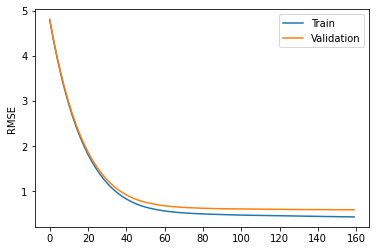

In [20]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Tune hyperparameters values and train model using .fit with Train data
# you can use l1 and l2 regularization terms too
# after training calculate Root Mean Square Error (RMSE) for validation data
#################################################################################
from sklearn.metrics import confusion_matrix

learning_rate = np.arange(0.02, 0.2, 0.01)
n_estimators = np.arange(100, 250, 10)
max_depth = np.arange(4, 32, 2)
colsample_bytree = np.arange(0.5, 1, 0.1)
subsample = np.arange(0.5, 1, 0.1)


###These values are the result of the below code. because of the long running
###I have written theme here. In order to run the tuning operation, please comment 
###this part and uncomment the tuning parts. although by evaluating the models 
###rmse on the validation data, I found that some of the variables, can be better changed
##in the manner below. So these values are almost the result of the code.
best_rmse = 0
best_lr = 0.05
best_n = 160
best_max_depth = 6
best_colsample_bytree = 0.5
best_subsample = 0.9

size = len(Y_val_new)


model = xgboost.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, 
                                colsample_bytree = 0.5,
                                max_depth = 6, 
                                subsample = 0.5, 
                                n_estimators = 100,
                                eval_metric='rmse')
"""for l in learning_rate:
    model.set_params(learning_rate = l)
    model.fit(X_train_up,Y_train_up)
    preds = model.predict(X_val)
    preds = np.array(preds)
    preds[np.argwhere(preds <= 7)] = -1
    preds[np.argwhere(preds > 7)] = 1
    tn, fp, fn, tp = confusion_matrix(Y_val_new, preds).ravel()
    test_percision = tp / (tp + fp)
    test_recall = tp / (tp + fn)
    f1 = (2 * test_percision * test_recall) / (test_percision + test_recall)
    if f1 > best_rmse:
      best_rmse = f1
      best_lr = l
    print(l, f1)"""
    
model.set_params(learning_rate = best_lr)

"""best_max_depth = 0
best_n = 0
best_rmse = 0
for n in n_estimators:
  for m in max_depth:
    model.set_params(n_estimators=n, max_depth = m)
    model.fit(X_train_up,Y_train_up)
    preds = model.predict(X_val)
    preds = np.array(preds)
    preds[np.argwhere(preds <= 7)] = -1
    preds[np.argwhere(preds > 7)] = 1
    tn, fp, fn, tp = confusion_matrix(Y_val_new, preds).ravel()
    test_percision = tp / (tp + fp)
    test_recall = tp / (tp + fn)
    f1 = (2 * test_percision * test_recall) / (test_percision + test_recall)
    if f1 > best_rmse:
      best_rmse = f1
      best_max_depth = m
      best_n = n
    print(m, n, f1)"""


model.set_params(n_estimators= best_n, max_depth = best_max_depth)

"""best_colsample_bytree = 0
best_subsample = 0
best_rmse = 0

for cb in colsample_bytree:
  for ss in subsample:
    model.set_params(colsample_bytree=cb, subsample = ss)
    model.fit(X_train_up,Y_train_up)
    preds = model.predict(X_val)
    preds = np.array(preds)
    preds[np.argwhere(preds <= 7)] = -1
    preds[np.argwhere(preds > 7)] = 1
    tn, fp, fn, tp = confusion_matrix(Y_val_new, preds).ravel()
    test_percision = tp / (tp + fp)
    test_recall = tp / (tp + fn)
    f1 = (2 * test_percision * test_recall) / (test_percision + test_recall)
    if f1 > best_rmse:
      best_rmse = f1
      best_colsample_bytree = cb
      best_subsample = ss
    print(cb, ss, f1)"""
    

model.set_params(colsample_bytree=best_colsample_bytree, subsample = best_subsample)


    


model.fit(X_train,Y_train, eval_metric="rmse", 
              eval_set=[(X_train, Y_train), (X_val, Y_val)],
                verbose=False)

preds = model.predict(X_val)
validation_rmse = np.sqrt(mean_squared_error(Y_val, preds))
#################################################################################
#                                   THE END                                     #
#################################################################################
print("Validation RMSE: %.3f" % validation_rmse)
plot_model_results(model.evals_result())

In [21]:






model.fit(X_train_up,Y_train_up, eval_metric="rmse", 
              eval_set=[(X_train_up, Y_train_up), (X_val, Y_val)],
                verbose=False)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.05,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
             n_estimators=160, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.9, verbosity=1)

### 3.2 Ploting Feature importance

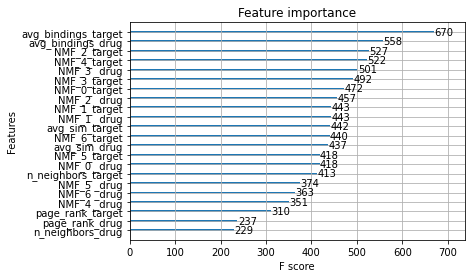

In [22]:
xgboost.plot_importance(model);

### 3.2 Evaluation

Let's make our perdiction binary. either a drug is binded to target or not, use $pK_d$ > 7 threshold as binded (drug-target) pair.

In [23]:
from sklearn.metrics import confusion_matrix
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Calculate RMSE for Test data. after that
# Calculate accuracy, precision, recall, f1-score for X_test
# for binary prediction setting. you can use confution_matrix from sklearn
#################################################################################

#cancer.target = np.where(cancer.target==0, -1, cancer.target)

preds = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(Y_test, preds))
preds = np.array(preds)
true = Y_test.values

preds[np.argwhere(preds <= 7)] = -1
preds[np.argwhere(preds > 7)] = 1


size = len(true)
tn, fp, fn, tp = confusion_matrix(Y_test_new, preds).ravel()

print(tn, fp, fn, tp)
test_acc = (tp + tn) / size
test_percision = tp / (tp + fp)
test_recall = tp / (tp + fn)
test_f1 = (2 * test_percision * test_recall) / (test_percision + test_recall)


#################################################################################
#                                   THE END                                     #
#################################################################################
print("Test RMSE: %.3f" % test_rmse)
print("Test Accuracy: %.3f" % test_acc)
print("Test Percision: %.3f" % test_percision)
print("Test Recall: %.3f" % test_recall)
print("Test F1-Score: %.3f" % test_f1)

5377 151 210 274
Test RMSE: 0.620
Test Accuracy: 0.940
Test Percision: 0.645
Test Recall: 0.566
Test F1-Score: 0.603


## 4.Classification (25 Points)

Change Binding values to binary values with threshold $pK_d$ > 7 
and use X_train to train any Classifier method that you like.\
Report `accuracy`, `precision`, `recall`, `f1-score` for X_test. 



In [0]:
from sklearn.utils import resample



X = pd.concat([X_train, pd.DataFrame(Y_train_new , columns = ["class"])], axis=1)

pos = X[X["class"]== 1]
neg = X[X["class"]== -1]

pos_up = resample(pos, replace=True, n_samples=len(neg) , random_state=11)

X_train_up = pd.concat([pos_up, neg], axis = 0)

Y_train_up = X_train_up["class"]
X_train_up = X_train_up.drop(columns = ['class'])


In [44]:
model = xgboost.XGBClassifier(learning_rate=best_lr, n_estimators=300, max_depth=10, objective='binary:logistic', colsample_bytree=best_colsample_bytree, subsample=best_colsample_bytree)
from sklearn.ensemble import RandomForestClassifier

#model = RandomForestClassifier( criterion="entropy", bootstrap=True, random_state=10,  max_features="auto", max_depth = 4,
#                           n_estimators = 100)




model.fit(X_train_up, Y_train_up)
  





XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, verbosity=1)

In [45]:
val_preds = model.predict(X_val)

tn, fp, fn, tp = confusion_matrix(Y_val_new, val_preds).ravel()
print(tn, fp, fn, tp)
test_acc = (tp + tn) / len(Y_val_new)
test_percision = tp / (tp + fp)
test_recall = tp / (tp + fn)
test_f1 = (2 * test_percision * test_recall) / (test_percision + test_recall)

print("Test Accuracy: %.3f" % test_acc)
print("Test Percision: %.3f" % test_percision)
print("Test Recall: %.3f" % test_recall)
print("Test F1-Score: %.3f" % test_f1)

2685 53 137 131
Test Accuracy: 0.937
Test Percision: 0.712
Test Recall: 0.489
Test F1-Score: 0.580


In [46]:
preds = model.predict(X_test)

tn, fp, fn, tp = confusion_matrix(Y_test_new, preds).ravel()
print(tn, fp, fn, tp)
size = len(Y_test_new)
test_acc = (tp + tn) / size
test_percision = tp / (tp + fp)
test_recall = tp / (tp + fn)
test_f1 = (2 * test_percision * test_recall) / (test_percision + test_recall)


print("Test Accuracy: %.3f" % test_acc)
print("Test Percision: %.3f" % test_percision)
print("Test Recall: %.3f" % test_recall)
print("Test F1-Score: %.3f" % test_f1)


5417 111 212 272
Test Accuracy: 0.946
Test Percision: 0.710
Test Recall: 0.562
Test F1-Score: 0.627


# Extra Points

There is 5 extra points in parts 3 & 4 rewarded to the top 15% students with the best results. Your model will be trained again with a random seed on our dataset. Please have in mind:
- You should only use train or validation data for training phase of your model.
- Your code must be readable and runnable in other enviroments.
- If you are going to use other libraries, mention them.


<ul>
<li>I have not used any new libraries. Although I have used the resample function of sklearn
<li>because the data was very unbalanced, I have used upsampling technique to equalize the size of two classes. This improves the recall measurement.
</ul>

